In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_dir = Path("data/huge_stock_market_dataset/")
results_dir = Path("results")

In [3]:
ts_info = pd.read_csv(dataset_dir / "selected.csv")
ts_info["ts_id"] = ts_info.index
results = []
for results_type in ("pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"):
    for model in ("LSTM", "TCN", "cbr"):
        df = pd.read_csv(results_dir / f"{results_type}_{model}.csv")
        df["model"] = model
        df["results_type"] = results_type
        results.append(df)
results = pd.concat(results)
results["model"].replace("cbr", "CatBoostRegressor", inplace=True)
results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
                                ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
                                inplace=True)
results

,train,val,model,results_type
0,0.095871,0.091669,LSTM,train set
1,0.038049,0.052777,LSTM,train set
2,0.007282,0.005239,LSTM,train set
3,0.009842,0.010587,LSTM,train set
4,0.016299,0.012812,LSTM,train set
...,...,...,...,...
19,0.009250,0.005596,CatBoostRegressor,TTS GAN synthetic data
20,3874.674253,3874.674607,CatBoostRegressor,TTS GAN synthetic data
21,0.008822,0.007025,CatBoostRegressor,TTS GAN synthetic data
22,0.024266,0.029026,CatBoostRegressor,TTS GAN synthetic data


In [7]:
print(results[results.results_type == "TTS GAN synthetic data"].groupby("model").mean())
results = results[results.results_type != "TTS GAN synthetic data"]

                        train         val
model                                    
CatBoostRegressor  161.471475  161.468091
LSTM                 0.753722    0.743008
TCN                  0.055142    0.051338


In [8]:
results_agg = results.groupby(by=["model", "results_type"], axis=0).agg(train=("train", "mean"), val=("val", "mean"))
results_agg

train       val
model             results_type                                  
CatBoostRegressor FourierFlow synthetic data  0.023682  0.020897
                  QuantGAN synthetic data     0.025169  0.020839
                  RealNVP synthetic data      0.022648  0.020972
                  train set                   0.023467  0.020813
LSTM              FourierFlow synthetic data  0.022806  0.022078
                  QuantGAN synthetic data     0.025344  0.020695
                  RealNVP synthetic data      0.020826  0.021979
                  train set                   0.023882  0.020938
TCN               FourierFlow synthetic data  0.021676  0.021634
                  QuantGAN synthetic data     0.025414  0.020757
                  RealNVP synthetic data      0.020013  0.021960
                  train set                   0.022132  0.021120

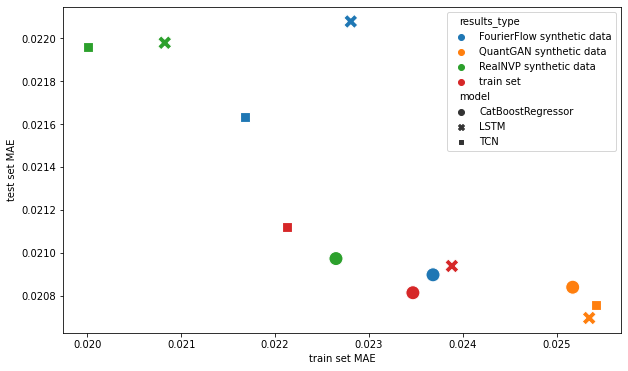

In [9]:
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.scatterplot(data=results_agg, x="train", y="val", hue="results_type", style="model", s=200, ax=ax)
ax.set_xlabel("train set MAE")
ax.set_ylabel("test set MAE")
plt.show()

<AxesSubplot:xlabel='model', ylabel='val'>

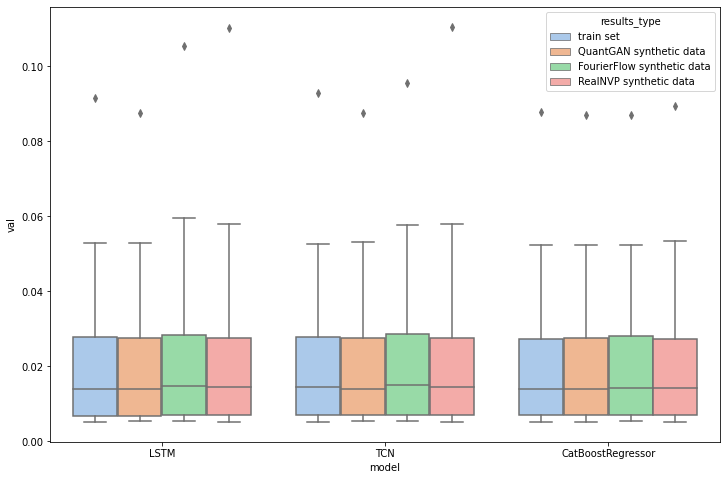

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(data=results, x="model", y="val", hue="results_type", palette="pastel", ax=ax)

In [11]:
results.merge(ts_info, left_index=True, right_index=True)

,train,val,model,results_type,filename,length,uptrending_rate,ts_id
0,0.095871,0.091669,LSTM,train set,opgnw.us.txt,444,0.388262,0
0,0.076018,0.092941,TCN,train set,opgnw.us.txt,444,0.388262,0
0,0.098840,0.087899,CatBoostRegressor,train set,opgnw.us.txt,444,0.388262,0
0,0.107613,0.087685,LSTM,QuantGAN synthetic data,opgnw.us.txt,444,0.388262,0
0,0.107758,0.087613,TCN,QuantGAN synthetic data,opgnw.us.txt,444,0.388262,0
...,...,...,...,...,...,...,...,...
23,0.017384,0.008792,TCN,FourierFlow synthetic data,hig.us.txt,5514,0.506258,23
23,0.017381,0.008894,CatBoostRegressor,FourierFlow synthetic data,hig.us.txt,5514,0.506258,23
23,0.018116,0.008616,LSTM,RealNVP synthetic data,hig.us.txt,5514,0.506258,23
23,0.017147,0.008774,TCN,RealNVP synthetic data,hig.us.txt,5514,0.506258,23


# Gains

In [12]:
pure = results[results.results_type == "train set"]
gains = None
for synth_rt in (x for x in results.results_type.unique() if x != "train set"):
    synth_df = results[results.results_type == synth_rt]
    gain = (pure.groupby([pure.index, "model"]).mean() - synth_df.groupby([synth_df.index, "model"]).mean()) / pure.groupby([pure.index, "model"]).mean() * 100
    gain.index, gain["model"] = gain.index.get_level_values(0), gain.index.get_level_values(1)
    synth_rt = synth_rt.split(' ')[0]
    gain.rename(columns={"train": f"train_{synth_rt}", "val": f"val_{synth_rt}"}, inplace=True)
    gain["ts_id"] = gain.index
    if gains is None:
        gains = gain
    else:
        gains = gains.merge(gain, on=["model", "ts_id"])

gains = gains.merge(ts_info, on="ts_id")
gains

,train_QuantGAN,val_QuantGAN,model,ts_id,train_FourierFlow,val_FourierFlow,train_RealNVP,val_RealNVP,filename,length,uptrending_rate
0,-14.984101,1.092810,CatBoostRegressor,0,0.009923,1.075458,8.902737,-1.783872,opgnw.us.txt,444,0.388262
1,-12.248072,4.345460,LSTM,0,44.364159,-14.995131,78.998564,-20.307157,opgnw.us.txt,444,0.388262
2,-41.752634,5.733166,TCN,0,43.435590,-2.795060,70.139684,-18.988814,opgnw.us.txt,444,0.388262
3,-7.121055,-0.412516,CatBoostRegressor,1,1.888017,-0.154011,4.250660,-2.036028,dare.us.txt,905,0.431416
4,-5.089717,-0.094556,LSTM,1,0.437285,-12.952974,8.553213,-9.833632,dare.us.txt,905,0.431416
...,...,...,...,...,...,...,...,...,...,...,...
67,-0.722312,0.048177,LSTM,22,-0.620685,-0.167292,-0.198201,0.309734,gfi.us.txt,6686,0.454899
68,-8.620905,1.549468,TCN,22,-7.438851,1.511683,-6.349097,2.275034,gfi.us.txt,6686,0.454899
69,-5.009985,-0.304437,CatBoostRegressor,23,3.046810,0.333041,3.693611,0.068648,hig.us.txt,5514,0.506258
70,-9.876057,1.136465,LSTM,23,-9.663885,-0.102063,-8.688046,1.411714,hig.us.txt,5514,0.506258


In [13]:
gains.groupby(["model"]).mean().drop(columns=["ts_id", "length", "uptrending_rate"])

,train_QuantGAN,val_QuantGAN,train_FourierFlow,val_FourierFlow,train_RealNVP,val_RealNVP
model,,,,,,
CatBoostRegressor,-6.744821,-0.484926,-1.865237,-0.772547,2.976504,-0.424581
LSTM,-4.636783,-0.137742,-1.264897,-3.044220,3.081292,-1.442988
TCN,-9.952288,0.303305,-2.759000,-1.897040,2.482338,-0.783130


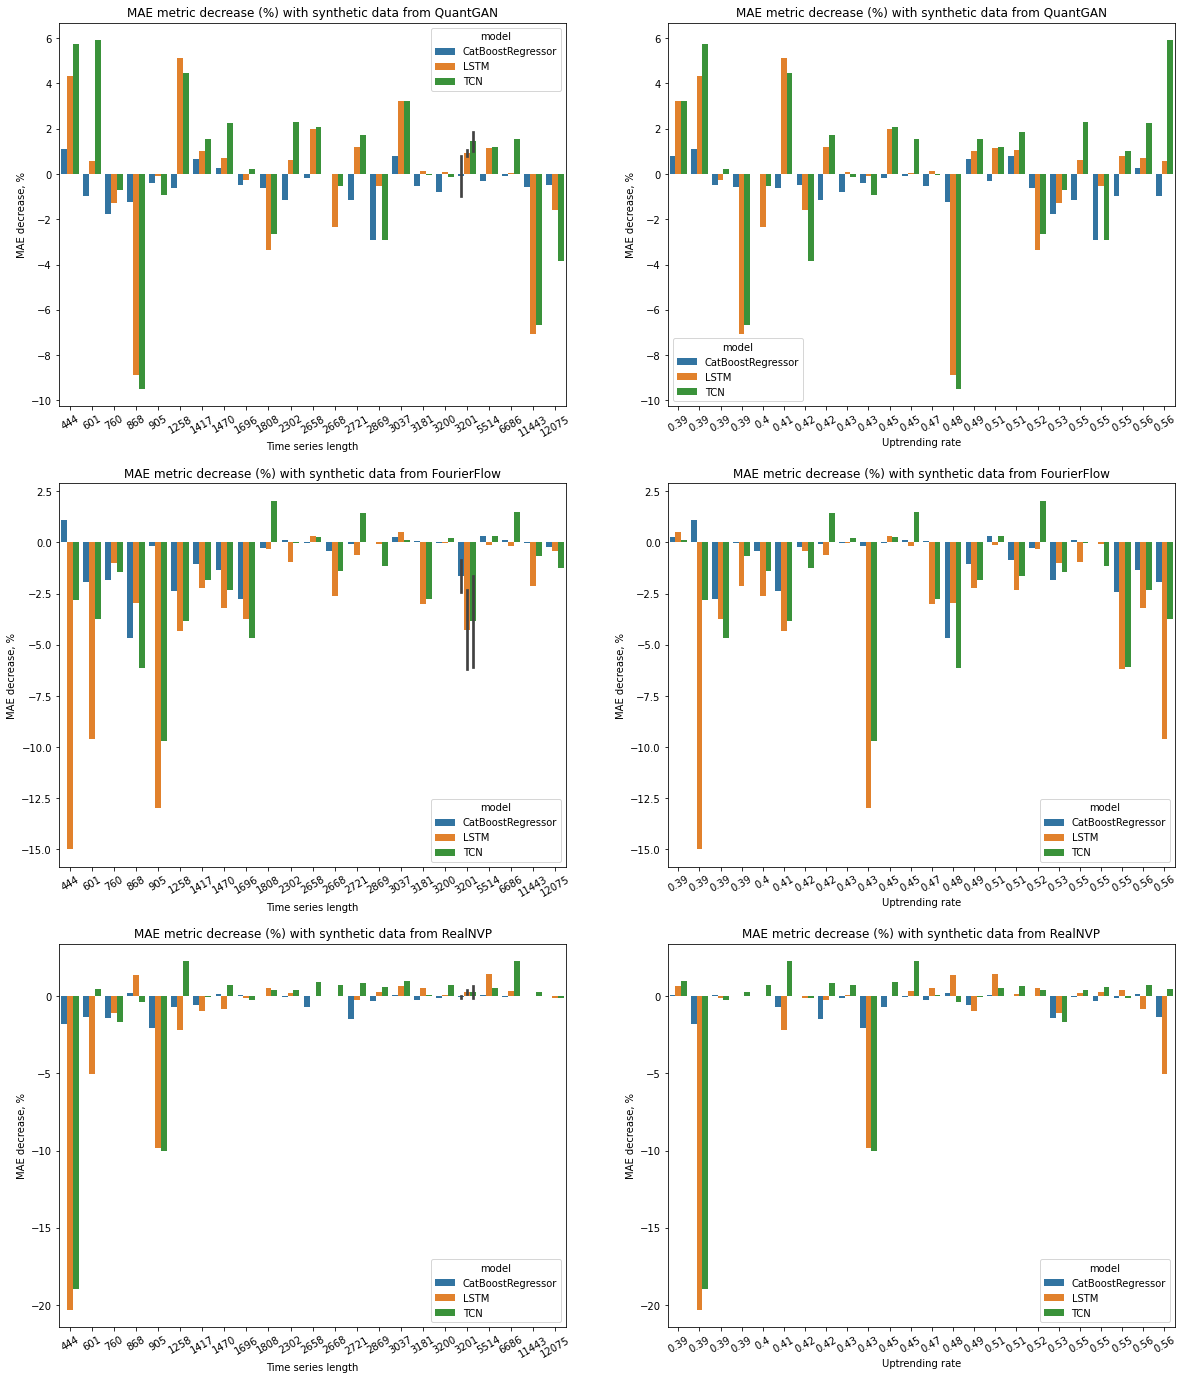

In [15]:
synth_models = ["QuantGAN", "FourierFlow", "RealNVP"]
fig, axs = plt.subplots(len(synth_models), 2, figsize=(20, 8 * len(synth_models)))

for i in range(len(synth_models)):
    sns.barplot(data=gains, x="length", y=f"val_{synth_models[i]}", hue="model", ax=axs[i][0])
    axs[i][0].set_xlabel("Time series length")
    axs[i][0].set_xticklabels(sorted(gains["length"].unique()), rotation=30)
    axs[i][0].set_ylabel("MAE decrease, %")

    sns.barplot(data=gains, x="uptrending_rate", y=f"val_{synth_models[i]}", hue="model", ax=axs[i][1])
    axs[i][1].set_xlabel("Uptrending rate")
    axs[i][1].set_xticklabels(map(lambda x: round(x, 2), sorted(gains.uptrending_rate.unique())), rotation=30)
    axs[i][1].set_ylabel("MAE decrease, %")

    for j in range(2): axs[i][j].set_title(f"MAE metric decrease (%) with synthetic data from {synth_models[i]}")
    
plt.show()